In [ ]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
#set this variable to true if you are using light more, or false if you are using dark mode.
JUPYTER = False
RANDOM_STATE = 42

In [ ]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = 60
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [ ]:
def get_chunks(urls,limit=0,verbose = 1,base_name = "temp",file_path="",file_format='.csv',loading_chunks = True):
    #downloads all data from their url(s)
    for i,url in enumerate(urls):
        if limit:
            if i == limit:
                return
        if loading_chunks:
            file_name = base_name + str(i + 1)
        else:
            file_name = base_name
        #checks if file already exists
        if os.path.exists(file_path + file_name + file_format):
            print(f"{file_name} already exists.")
            continue
        if i % verbose == 0:
            print(f"Downloading {file_name}...")
        r = requests.get(url)
        with open(file_path + file_name + file_format, 'wb') as fd:
            for chunk in r.iter_content():
                #save file in the current directory of the notebook
                fd.write(chunk)

In [ ]:
def get_all_file_names(base_name,limit_num):
    return [base_name + str(num) for num in range(1,limit_num + 1)]

In [ ]:
def read_chunks(files,file_path = "",file_format = ".csv"):
    #reads chunks csvs and converts them to a dataframe format
    final_df = []
    for file in files:
        df = pd.read_csv(file_path + file + file_format)
        final_df.append(df)
    #function returns a list of dfs
    return final_df

In [ ]:
def group_up_chunks(dfs):
    #adds up all dataframes together
    return pd.concat(dfs)

In [ ]:
def check_no_missing_data(shape_loaded,shape_actual):
    actual_shape_loaded = (shape_loaded / shape_actual) * 100
    return actual_shape_loaded

In [ ]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
            
    return word_to_vec_map

In [ ]:
def custom_f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.
chunk_7 already exists.
chunk_8 already exists.
chunk_9 already exists.
chunk_10 already exists.
chunk_11 already exists.
chunk_12 already exists.
chunk_13 already exists.
chunk_14 already exists.
chunk_15 already exists.
chunk_16 already exists.
chunk_17 already exists.
chunk_18 already exists.
chunk_19 already exists.
chunk_20 already exists.
chunk_21 already exists.
chunk_22 already exists.
chunk_23 already exists.
chunk_24 already exists.
chunk_25 already exists.
chunk_26 already exists.
chunk_27 already exists.
chunk_28 already exists.
chunk_29 already exists.
chunk_30 already exists.
chunk_31 already exists.
chunk_32 already exists.
chunk_33 already exists.
chunk_34 already exists.
chunk_35 already exists.
chunk_36 already exists.
chunk_37 already exists.
chunk_38 already exists.
chunk_39 already exists.
chunk_40 already exists.
chunk_41 

In [ ]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [ ]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [ ]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [ ]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [ ]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [ ]:
review_data = df[['text', 'stars']].copy()

In [ ]:
review_data

,text,stars
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
116480,late addition service iccu apple pay iccu debi...,5.0
116481,spot offer great affordable east weekend paddl...,5.0
116482,home depot need get lot demential lumber seem ...,4.0
116483,m feel like ignore caloriecounting indulge fla...,5.0


In [ ]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [ ]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [ ]:
review_data

,full_review_text,star_rating
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
6990275,late addition service iccu apple pay iccu debi...,5.0
6990276,spot offer great affordable east weekend paddl...,5.0
6990277,home depot need get lot demential lumber seem ...,4.0
6990278,m feel like ignore caloriecounting indulge fla...,5.0


In [ ]:
review_data.isnull().sum()

full_review_text    44
star_rating          0
dtype: int64

In [ ]:
review_data.dropna()

,full_review_text,star_rating
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
6990275,late addition service iccu apple pay iccu debi...,5.0
6990276,spot offer great affordable east weekend paddl...,5.0
6990277,home depot need get lot demential lumber seem ...,4.0
6990278,m feel like ignore caloriecounting indulge fla...,5.0


Text(0.5, 1.0, 'Word Cloud of Unique Words')

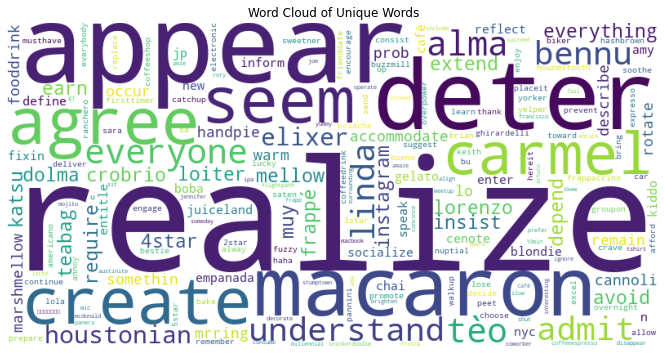

In [ ]:
# Extract unique words from the text data
unique_words = set(' '.join(review_data['full_review_text']).split())

# Create a word cloud of the unique words
unique_wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=set(nltk.corpus.stopwords.words('english')),random_state = RANDOM_STATE).generate(' '.join(unique_words))
plt.figure(figsize=(12, 6))
plt.imshow(unique_wordcloud)
plt.axis('off')
plt.title('Word Cloud of Unique Words')

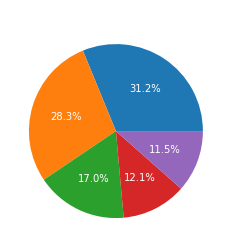

In [ ]:
review_text_no_stop_words = pd.Series([remove_stop_words(review) for review in review_data['full_review_text']])
# Split the text into words and count their occurrences
text_data_str = ' '.join(review_text_no_stop_words.tolist())

# Split the text into words and count their occurrences
word_counts = collections.Counter(text_data_str.split())

# Get the most common words and their counts
most_common = word_counts.most_common(5)
labels = [word[0] for word in most_common]
values = [word[1] for word in most_common]

# Create the pie chart
if JUPYTER:
    color = "black"
else:
    color = "white"
plt.pie(values, labels=labels, autopct='%1.1f%%', textprops={'color': color})
plt.title('Most Common Words',color=color)
plt.show()

Text(0, 0.5, 'Word')

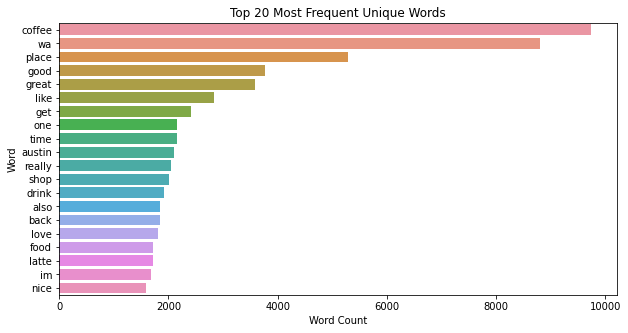

In [ ]:
# Count the number of occurrences of each unique word and create a bar chart of the top 20 most frequent unique words
unique_word_count = review_text_no_stop_words.str.split(expand=True).stack().value_counts()
top_unique_words = unique_word_count.loc[unique_word_count.index.isin(unique_words)].head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_unique_words.values, y=top_unique_words.index)
plt.title('Top 20 Most Frequent Unique Words')
plt.xlabel('Word Count')
plt.ylabel('Word')

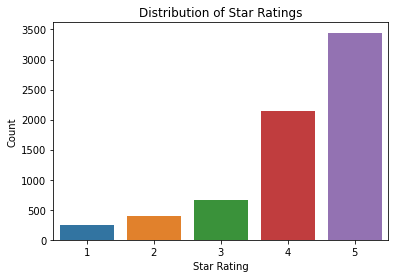

In [ ]:
# Create a countplot of the star ratings using Seaborn
sns.countplot(x=review_data['star_rating'])

# Add some labels and titles
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')

# Show the plot
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


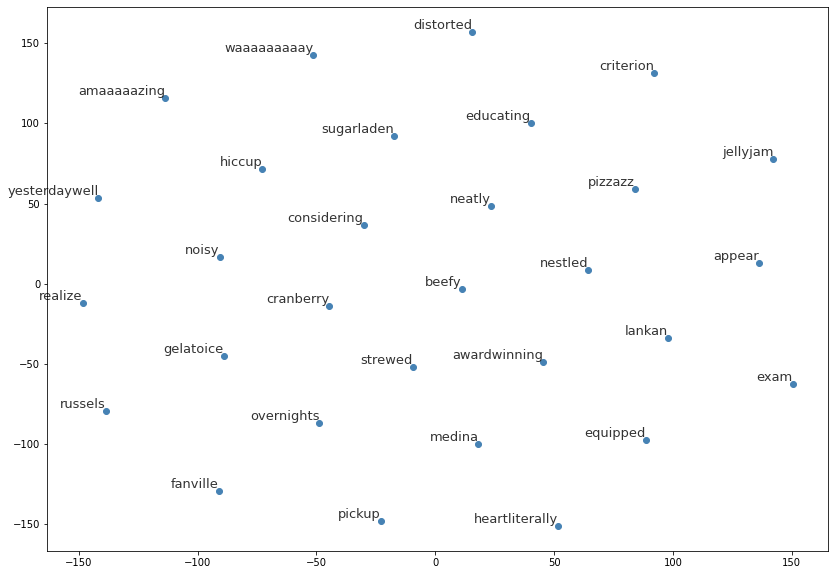

In [ ]:
#Visualizing the word vector space of the dataset
unique_words_no_stop_words = remove_stop_words(''.join(list(unique_words)))
vectorizer = CountVectorizer()
word_embeddings = vectorizer.fit_transform(review_text_no_stop_words)
viz_words = 30
tsne = TSNE()
embed_tsne = tsne.fit_transform(word_embeddings[:viz_words, :])
fig, ax = plt.subplots(figsize=(14, 10))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    int_to_vocab = {i: word for i, word in enumerate(set(unique_words))}
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.8, fontsize=13, color='black', horizontalalignment='right', verticalalignment='bottom')